In [4]:
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet import MobileNet
from keras.utils import np_utils
import matplotlib.pyplot as plt
from pandas import DataFrame

%matplotlib inline

## Load Data

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

[7]


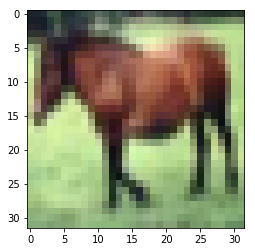

In [6]:
print(y_train[7])   #Convince yourself that the labels are consistent with the data.  See https://www.cs.toronto.edu/~kriz/cifar.html
plt.imshow(x_train[7,:,:,:])

## Clean Data

In [7]:
x_train_unrolled = x_train.reshape(-1,32*32*3) / 256
print(x_train_unrolled.shape)
y_train_encoded = np_utils.to_categorical(y_train)

x_test_unrolled = x_test.reshape(-1,32*32*3) / 256
y_test_encoded = np_utils.to_categorical(y_test)

(50000, 3072)


## Load Existing Neural Net

In [25]:
fresh = MobileNet(include_top = False, weights=None)
#fresh.summary()

In [26]:
rand_init_model = Sequential()

rand_init_model.add(Dense(32,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_adapter'))
rand_init_model.layers.extend(fresh.layers[1:])
rand_init_model.add(Dense(10,activation = 'softmax'))

rand_init_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_fresh = rand_init_model.fit(x_train_unrolled,y_train_encoded, epochs=15, batch_size = 4)



Epoch 1/10
50000/50000 [==============================] - 55s 1ms/step - loss: 2.0837 - acc: 0.2262
Epoch 2/10
50000/50000 [==============================] - 47s 943us/step - loss: 1.9599 - acc: 0.2878
Epoch 3/10
50000/50000 [==============================] - 45s 902us/step - loss: 1.9286 - acc: 0.2998
Epoch 4/10
50000/50000 [==============================] - 47s 943us/step - loss: 1.9155 - acc: 0.3113
Epoch 5/10
50000/50000 [==============================] - 52s 1ms/step - loss: 1.9022 - acc: 0.3166
Epoch 6/10
50000/50000 [==============================] - 55s 1ms/step - loss: 1.8841 - acc: 0.3263
Epoch 7/10
50000/50000 [==============================] - 53s 1ms/step - loss: 1.8716 - acc: 0.3313
Epoch 8/10
50000/50000 [==============================] - 54s 1ms/step - loss: 1.8652 - acc: 0.3351
Epoch 9/10
50000/50000 [==============================] - 54s 1ms/step - loss: 1.8604 - acc: 0.3353
Epoch 10/10
50000/50000 [==============================] - 56s 1ms/step - loss: 1.8421 - acc: 

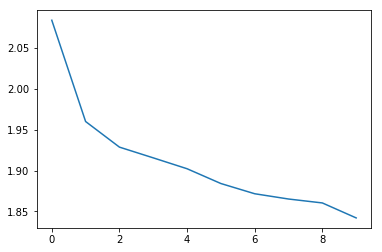

In [31]:
plt.plot(history_fresh.history['loss'])
#plt.plot(history_fresh.history['acc'])

In [28]:
#Documentation for MobileNet says smaller shapes allowed, but throws error.  https://keras.io/applications/#mobilenet
#Thus, we have to adapt a new model to take the dimensions of our data (32,32,3).
#Initializing w/ input_shape will create input layer which we will later remove.  Hacky.
trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet') 

In [29]:
%%time


#Create new model to add the trained model into.  
transfer_model = Sequential()
transfer_model.add(Dense(32,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_adapter'))
    
    
#Extend list of layers to include layers of trained_model, except for the first input layer.
#Check summary on model to see the layer structures.
#Remember, include_top = False has already chopped off the classification layers.
transfer_model.layers.extend(trained_model.layers[1:])
transfer_model.add(Dense(10, activation = 'softmax'))

#Experiment: freeze all trainable params.  What do you expect to happen to the acc?  Check summary.
#new_model.trainable = False  


transfer_model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history_transfer = transfer_model.fit(x_train_unrolled,y_train_encoded,epochs=15,batch_size=4)


Epoch 1/10
50000/50000 [==============================] - 59s 1ms/step - loss: 2.0488 - acc: 0.2374
Epoch 2/10
50000/50000 [==============================] - 59s 1ms/step - loss: 1.9405 - acc: 0.2964
Epoch 3/10
50000/50000 [==============================] - 53s 1ms/step - loss: 1.9256 - acc: 0.3070
Epoch 4/10
50000/50000 [==============================] - 59s 1ms/step - loss: 1.8966 - acc: 0.3170
Epoch 5/10
50000/50000 [==============================] - 56s 1ms/step - loss: 1.8775 - acc: 0.3237
Epoch 6/10
50000/50000 [==============================] - 55s 1ms/step - loss: 1.8659 - acc: 0.3323
Epoch 7/10
50000/50000 [==============================] - 55s 1ms/step - loss: 1.8624 - acc: 0.3356
Epoch 8/10
50000/50000 [==============================] - 52s 1ms/step - loss: 1.8536 - acc: 0.3378
Epoch 9/10
50000/50000 [==============================] - 57s 1ms/step - loss: 1.8421 - acc: 0.3420
Epoch 10/10
50000/50000 [==============================] - 62s 1ms/step - loss: 1.8376 - acc: 0.3447

In [ ]:
#transfer_model.summary()

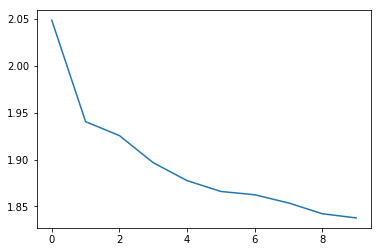

In [30]:
plt.plot(history_transfer.history['loss'])